In [126]:
import numpy as np
import scipy as sp
import pathos
from qutip import sigmaz, sigmax, propagator, qeye
import time
import itertools
import matplotlib.pyplot as plt

## Trick #1: vectorizing

Say you have a propagator you want to apply to a collection of states. You can apply the propagator to the states one by one, for-loop style, or you can "vectorize" and perform the computation as one big matrix multiplication. Classic example of memory-time tradeoff

In [141]:
num_states = 10000
dim = 10
rng = np.random.default_rng(183767590)
# collection of unnormalized states of dimension dim
states = rng.standard_normal((dim, num_states))
# "propagator" of size dim x dim
prop = rng.standard_normal((dim ,dim))

In [142]:
# for loop style
result_for_loop = np.zeros_like(states)
# python does not intelligently parallelize for loops.
# this is to be contrasted with languages like Julia where 
# I have heard that you can just "write a for loop" and it will be fast,
# though I have not extensively tested that myself
start_time = time.time()
for i, state in enumerate(states.T):
    result_for_loop[:, i] = prop @ state
end_time = time.time()
print(f"for loop took {end_time - start_time} seconds")

for loop took 0.04199695587158203 seconds


In [143]:
# vectorized style
start_time = time.time()
result_vectorized = np.einsum('ij,jk->ik', prop, states)
end_time = time.time()
print(f"vectorized operation took {end_time - start_time} seconds")

vectorized operation took 0.002389192581176758 seconds


In [144]:
np.allclose(result_for_loop, result_vectorized)

True

## Trick #2: using pathos for explicit multiprocessing

Say you want to perform a costly, multidimensional parameter sweep. This is an example of an "embarrassingly parallel" task where each run of your sweep is independent from the next.

In [145]:
control_dt = 0.1
omega = 2.0 * np.pi * 0.036

def get_map(num_cpus: int = 1):
    if num_cpus == 1:
        return map
    return pathos.pools.ProcessPool(nodes=num_cpus).map


def calc_fidel(prop, ideal_gate):
    return np.abs(np.trace(prop.dag() * ideal_gate) / 2)**2


def id_fidel(params):
    """for the given parameters, how well do you perform an identity operation?"""
    freq, amp = params
    def control_func(t, args=None):
        return 2.0 * np.pi * amp * np.cos(2.0 * np.pi * freq * t )
    H = [-0.5 * omega * sigmaz(), [sigmax(), control_func]]
    control_eval_times = np.linspace(0.0, 1.0 / freq, int(1./freq/control_dt))
    prop = propagator(H, control_eval_times)
    return calc_fidel(prop[-1], qeye(2))

In [146]:
num_pts = 50
freq_list = np.linspace(0.01, 0.1, num_pts)
amp_list = np.linspace(0.0, 0.06, num_pts)

In [134]:
num_cpus = 8
target_map = get_map(num_cpus)
# all possible pairs of the parameters you want to sweep over
freq_amp_product = itertools.product(freq_list, amp_list)

start_time = time.time()
result = np.array(list(target_map(id_fidel, freq_amp_product)))
# reshape into a matrix where location (i, j)
# is associated with the result from freq_list[i], amp_list[j]
fidel_mat = np.reshape(result, (num_pts, num_pts))
# print(id_fidel((freq_list[5], amp_list[10]))==fidel_mat[5, 10])
end_time = time.time()
print(end_time - start_time, num_cpus)

7.741633176803589 8


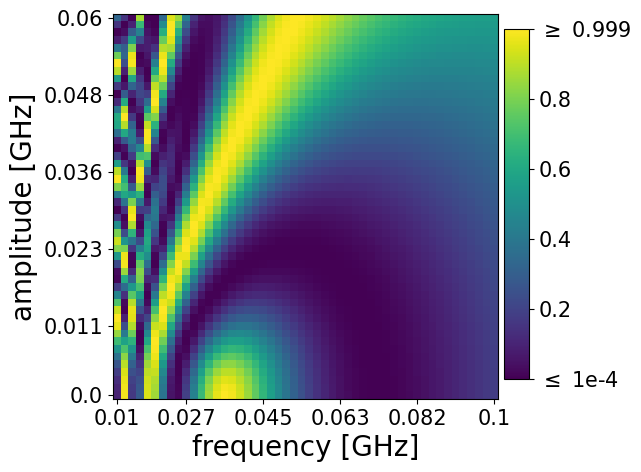

In [137]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(fidel_mat.T, origin='lower')
plt.xlabel('frequency [GHz]', fontsize=20)
plt.ylabel('amplitude [GHz]', fontsize=20)
ticklabel_locations = np.linspace(0, num_pts-1, 6, dtype=int)
ax.set_xticks(ticklabel_locations)
ax.set_xticklabels(np.array(np.around(freq_list[ticklabel_locations], decimals=3), dtype=str),
                   fontsize=15)
ax.set_yticks(ticklabel_locations)
ax.set_yticklabels(np.array(np.around(amp_list[ticklabel_locations], decimals=3), dtype=str),
                   fontsize=15)
cax = plt.axes([0.91, 0.15, 0.05, 0.7])
cbar = plt.colorbar(im, cax=cax, ticks=[0.0001, 0.2, 0.4, 0.6, 0.8, 0.999])
cbar.ax.set_yticklabels([r'$\leq$ 1e-4', '0.2', '0.4', '0.6', '0.8',r'$\geq$ 0.999'],
                        fontsize=15)
plt.savefig('amp_freq_id.png', bbox_inches='tight')
plt.show()